## FIG. 5. Redirecting excess loads to precing roads when the occupancy $\rho_{ij}$ of a road exceeds its capacity.

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import osmnx as ox
import networkx as nx
import warnings

import cartopy.crs as ccrs
import matplotlib.ticker as mticker

labelsize = 20
pgf_with_latex = {  # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",  # change this if using xetex or lautex
    "text.usetex": True,  # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],  # blank entries should cause plots
    "font.sans-serif": [],  # to inherit fonts from the document
    "font.monospace": [],
    "axes.labelsize": labelsize,  # LaTeX default is 10pt font.
    "font.size": labelsize,
    "legend.fontsize": labelsize,  # Make the legend/label fonts
    "xtick.labelsize": labelsize,  # a little smaller
    "ytick.labelsize": labelsize,
    "figure.figsize": (12, 8),  # default fig size of 0.9 textwidth
    "pgf.preamble": "\n".join(
        [  # plots will use this preamble
            r"\usepackage[utf8]{inputenc}",
            r"\usepackage[T1]{fontenc}",
        ]
    ),
}
mpl.rcParams.update(pgf_with_latex)


from src import GermanMobiltyPanel as gmp
from src import RoadNetwork as rn
from src import PopulationFromRaster as pfr


### Some functions which have the same use as the function in src/effective_velocities, but for directed graphs (because the toygraph is a DiGraph). In the future it would be nice to expand the functions in src to all types of graphs.

In [6]:
def peak_loads_and_capacities(G, N_road):
    Gc = G.copy()
    pop = sum(nx.get_node_attributes(Gc, "population").values())
    loads = nx.get_edge_attributes(Gc, "load")
    lanes = nx.get_edge_attributes(Gc, "lanes")
    lanes_mod = dict((k, v) if v == 1 else (k, v - 1) for k, v in lanes.items())
    lengths = nx.get_edge_attributes(Gc, "length")

    tot_load = sum(loads.values())
    peak_load = {k: N_road * pop * (v / tot_load) for k, v in loads.items()}

    capacities = {
        e: lengths[e] * lanes_mod[e] / (2 * 5 * 1000 / 60 / 60 + 5)
        for e in Gc.edges(keys=True)
    }

    nx.set_edge_attributes(Gc, peak_load, "peak_load")
    nx.set_edge_attributes(Gc, capacities, "capacity")
    return Gc


def reroute_overloaded_roads(Gc, N_road):
    Gc = peak_loads_and_capacities(G, N_road)

    peak_loads = nx.get_edge_attributes(Gc, "peak_load")
    max_caps = nx.get_edge_attributes(Gc, "capacity")

    over_idxs = [e for e in Gc.edges(keys=True) if (peak_loads[e] - max_caps[e]) > 1e-3]

    print(len(over_idxs))
    print(sum(peak_loads.values()))

    for u, v, k in over_idxs:
        diff_load = Gc[u][v][k]["peak_load"] - Gc[u][v][k]["capacity"]

        pred_edges = nx.bfs_edges(Gc, u, reverse=True)

        for m, n in pred_edges:
            max_comp = Gc[n][m][0]["capacity"] - Gc[n][m][0]["peak_load"]
            if max_comp >= diff_load:
                Gc[n][m][0]["peak_load"] += diff_load
                Gc[u][v][k]["peak_load"] -= diff_load
                break
            elif (max_comp > 0) & (max_comp < diff_load):
                Gc[n][m][0]["peak_load"] += max_comp
                Gc[u][v][k]["peak_load"] -= max_comp
                diff_load -= max_comp

    peak_loads = nx.get_edge_attributes(Gc, "peak_load")
    max_caps = nx.get_edge_attributes(Gc, "capacity")

    over_idxs = [e for e in Gc.edges(keys=True) if (peak_loads[e] - max_caps[e]) > 1e-3]

    print(len(over_idxs))
    print(sum(peak_loads.values()))
    return Gc


def effective_rerouting_velocities(G, N_road):
    G_rerouted = reroute_overloaded_roads(G, N_road)
    edges = ox.graph_to_gdfs(G_rerouted, nodes=False)

    x_veh = 5
    t_react = 2

    lanes = np.maximum(edges["lanes"] - 1, np.ones(len(edges)))
    edges["effective_velocity"] = (
        (edges["length"] * lanes / (edges["peak_load"] * t_react) - x_veh / t_react)
        * 60
        * 60
        / 1000
    )
    edges["effective_velocity"] = edges["effective_velocity"].where(
        edges["speed_kph"] > edges["effective_velocity"], edges["speed_kph"]
    )
    # edges['effective_velocity'] = edges['effective_velocity'].where(edges['effective_velocity'] > 5, 5)
    return edges


def reroute_overloaded_roads_di(Gc):
    G = Gc.copy()
    peak_loads = nx.get_edge_attributes(G, "load")
    max_caps = nx.get_edge_attributes(G, "capacity")

    over_idxs = [e for e in G.edges() if (peak_loads[e] - max_caps[e]) > 1e-3]

    while len(over_idxs) > 0:
        for e in over_idxs:
            u, v = e
            diff_load = G[u][v]["load"] - G[u][v]["capacity"]
            G[u][v]["load"] -= diff_load
            pred_edges = G.in_edges(u)
            if len(pred_edges) == 0:
                warnings.warn(
                    f"No predecessor edges to {e} with spillover {diff_load}. Load can not be rerouted. This may impact the results."
                )

            for n, m in pred_edges:
                G[n][m]["load"] += diff_load / len(pred_edges)

        peak_loads = nx.get_edge_attributes(G, "load")
        over_idxs = [e for e in G.edges() if (peak_loads[e] - max_caps[e]) > 1e-3]

    return G


### Creating the toy graph, computing the loads, and rerouting them

In [7]:
G_small = nx.DiGraph()
G_small.add_nodes_from([0, 7])
G_small.add_edges_from([(0, 3), (1, 4), (2, 5), (3, 6), (4, 6), (5, 6), (6, 7)])
pos = {
    0: (0, 1),
    1: (0, 1 / 2),
    2: (0, 0),
    3: (1 / 3, 1),
    4: (1 / 3, 1 / 2),
    5: (1 / 3, 0),
    6: (2 / 3, 1 / 2),
    7: (1, 1 / 2),
}

load = dict(zip(G_small.edges(), [0.0, 0.0, 0.0, 1.0, 0.0, 0.7, 2.5]))
capacity = dict(zip(G_small.edges(), [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]))
nx.set_edge_attributes(G_small, load, "load")
nx.set_edge_attributes(G_small, capacity, "capacity")

G_small_r = reroute_overloaded_roads_di(G_small)


### Now we build a RoadNetwork from a bbox to show a real life example of load-rerouting. The loads are precalculated - otherwise the computation will take some time (aprox. $\sim$ 1 hour) depending on your system. Rerouting the excess load will also take some time (approx $\sim$ 1 minute) as the occupation is set quite high ($\gamma=0.15$)

In [9]:
west, east = 6.65, 7.4
south, north = 50.25, 50.75

driving_tags = [
    "motorway",
    "motorway_link",
    "trunk",
    "trunk_link",
    "primary",
    "primary_link",
    "secondary",
    "secondary_link",
    "tertiary",
    "tertiary_link",
    "unclassified",
    "residential",
]
highway_filter = f"w/highway={','.join(driving_tags)}"

region = rn.RoadNetwork(
    osmpbf="germany.osm.pbf",
    highway_filter=highway_filter,
    bbox=[north, south, west, east],
)
G = region.graph


region.loads("travel_time")
nodes, edges = ox.graph_to_gdfs(region.graph)

region.effective_velocities(0.15)
region.effective_spillover_velocities(0.15)


num(nodes)= 32253
num(edges)= 76950
The SIBC has already been computed and stored. Providing the stored values.


/Users/jonas/Documents/PHD/ahrvalley-analysis.nosync/src/EffectiveVelocities.py:263: RuntimeWarning: divide by zero encountered in scalar divide
  e: (lengths[e] * lanes_mod[e] / (peak_loads[e] * t_react) - x_veh / t_react)
/Users/jonas/Documents/PHD/ahrvalley-analysis.nosync/src/EffectiveVelocities.py:226: RuntimeWarning: divide by zero encountered in scalar divide
  lengths[e] * lanes_mod[e] / (spillover_loads[e] * t_react) - x_veh / t_react


### Create Figure

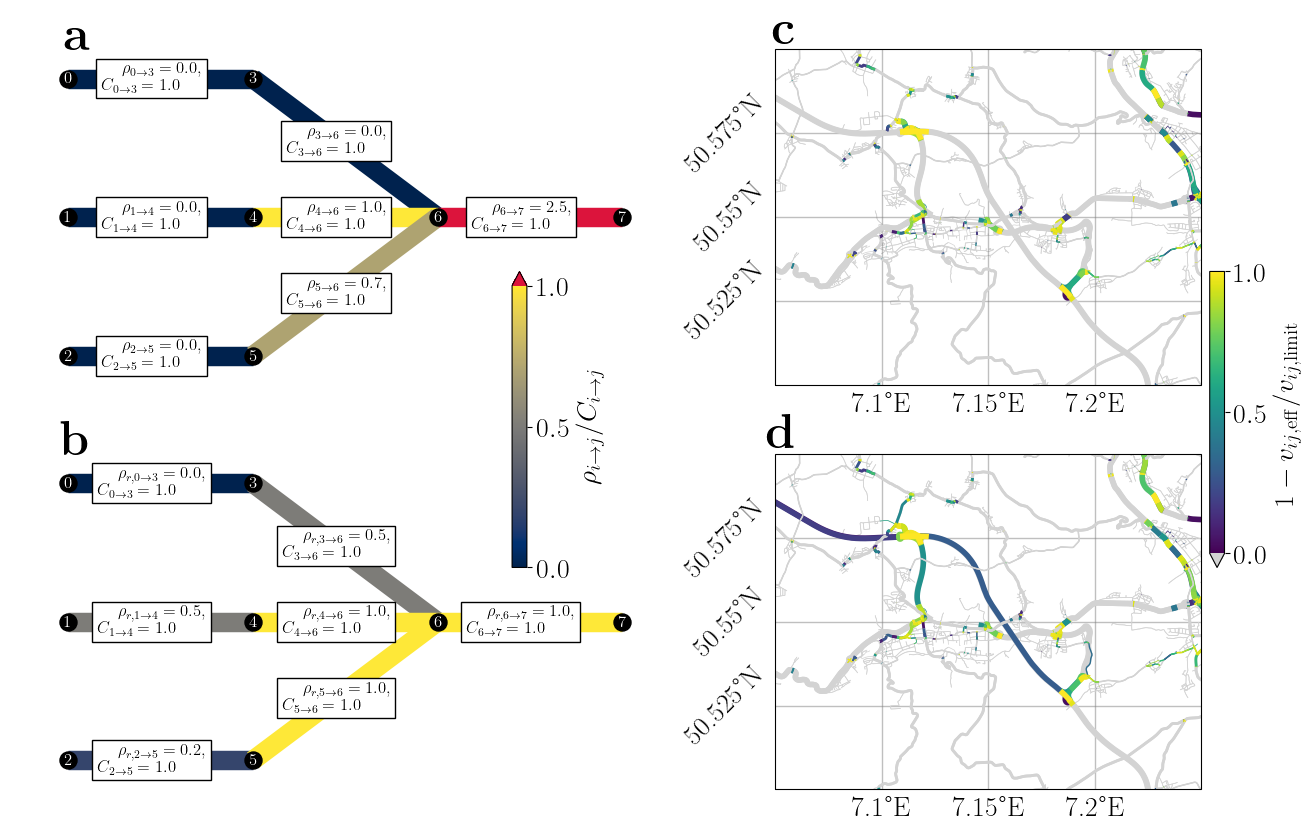

In [12]:
crs = ccrs.GOOGLE_MERCATOR
crs_proj4 = crs.proj4_init

fig, axs = plt.subplots(2, 2, figsize=(16, 8), subplot_kw={"projection": crs})
fontsize = 12
edge_width = 14

pos = {
    0: (0, 3),
    1: (0, 1.5),
    2: (0, 0),
    3: (2, 3),
    4: (2, 1.5),
    5: (2, 0),
    6: (4, 1.5),
    7: (6, 1.5),
}


fig.tight_layout(h_pad=2.5, w_pad=5)
#

labels = [r"\textbf{a}", r"\textbf{b}", r"\textbf{c}", r"\textbf{d}"]

ax0 = axs[0, 0]
ax1 = axs[1, 0]

for i, ax in enumerate([ax0, ax1]):
    ax.axis("off")
    ax.text(
        0.12,
        1.1,
        labels[i],
        transform=ax.transAxes,
        fontweight="bold",
        fontsize=35,
        va="top",
        ha="right",
    )

cmap = mpl.pyplot.get_cmap("cividis")
cmap.set_over("crimson")
# pos = { 0:(1,0), 1:(3/4,1/2), 2:(1/2,1), 3:(1/2,0), 4:(0,0), 5:(0,2/3), 6:(0,1) }


edg_labels = [
    rf'$\rho_{{ {u}\rightarrow{v} }}={round(data["load"],1)}$, \\ $C_{{ {u}\rightarrow{v} }}={data["capacity"]}$'
    for u, v, data in G_small.edges(data=True)
]
peak_loads = list(nx.get_edge_attributes(G_small, "load").values())


nx.draw_networkx_nodes(G_small, pos, ax=ax0, node_color="black", node_size=150)
nx.draw_networkx_labels(G_small, pos, ax=ax0, font_color="white", font_weight="bold")
nx.draw_networkx_edges(
    G_small,
    pos,
    ax=ax0,
    width=edge_width,
    arrows=False,
    arrowstyle=None,
    edge_color=peak_loads,
    edge_cmap=cmap,
    edge_vmin=0,
    edge_vmax=1,
    # connectionstyle="arc3,rad=0.1",
)
nx.draw_networkx_edge_labels(
    G_small,
    pos,
    ax=ax0,
    edge_labels=dict(zip(G_small.edges(), edg_labels)),
    font_size=fontsize,
    rotate=False,
    label_pos=0.55,
    bbox={"boxstyle": "square", "ec": (0.0, 0.0, 0.0), "fc": (1.0, 1.0, 1.0)},
)


############################################################

edg_labels = [
    rf'$\rho_{{ {{r,}} {u}\rightarrow{v} }}={round(data["load"],1)}$, \\ $C_{{{u}\rightarrow{v}}}={data["capacity"]}$'
    for u, v, data in G_small_r.edges(data=True)
]
peak_loads = list(nx.get_edge_attributes(G_small_r, "load").values())

nx.draw_networkx_nodes(G_small, pos, ax=ax1, node_color="black", node_size=150)
nx.draw_networkx_labels(G_small, pos, ax=ax1, font_color="white", font_weight="bold")

nx.draw_networkx_edges(
    G_small,
    pos,
    ax=ax1,
    width=edge_width,
    arrows=False,
    arrowstyle=None,
    edge_color=peak_loads,
    edge_cmap=cmap,
    edge_vmin=0,
    edge_vmax=1,
)
nx.draw_networkx_edge_labels(
    G_small,
    pos,
    ax=ax1,
    edge_labels=dict(zip(G_small.edges(), edg_labels)),
    font_size=fontsize,
    rotate=False,
    label_pos=0.55,
    bbox={"boxstyle": "square", "ec": (0.0, 0.0, 0.0), "fc": (1.0, 1.0, 1.0)},
)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []
cbar = plt.colorbar(
    sm, ax=axs[:, 0], shrink=0.4, ticks=[0, 0.5, 1], extend="max", pad=-0.2, aspect=20
)
cbar.set_label(r"$\rho_{i \rightarrow j}/C_{i \rightarrow j}$")


##################################################################

ax2 = axs[0, 1]
ax3 = axs[1, 1]
for i, ax in enumerate([ax2, ax3]):
    ax.set_extent([7.05, 7.25, 50.5, 50.6], crs=ccrs.PlateCarree())
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels={"bottom": "x", "left": "y"},
        linewidth=1,
        color="gray",
        alpha=0.5,
        linestyle="-",
    )
    gl.xlocator = mticker.FixedLocator([7.05, 7.1, 7.15, 7.2, 7.25])
    gl.ylocator = mticker.FixedLocator([50.5, 50.525, 50.55, 50.575, 50.6])
    gl.ylabel_style = {"rotation": 45}

    ax.text(
        0.05,
        1.12,
        labels[i + 2],
        transform=ax.transAxes,
        fontweight="bold",
        fontsize=35,
        va="top",
        ha="right",
    )

nodes, edges = ox.graph_to_gdfs(region.graph)
edges = edges.to_crs(crs_proj4)
cmap = mpl.pyplot.get_cmap("viridis")
cmap.set_under("lightgrey")


edges["data"] = 1 - edges["effective_velocity"] / edges["speed_kph"]
edges = edges.sort_values(by="data")
prim = ["motorway", "trunk", "primary", "motorway_link", "trunk_link", "primary_link"]
prim_edg = edges[edges["highway"].apply(lambda x: x in prim)]
sec = ["secondary", "secondary_link"]
sec_edg = edges[edges["highway"].apply(lambda x: x in sec)]
tert = ["tertiary", "tertiary_link"]
tert_edg = edges[edges["highway"].apply(lambda x: x in tert)]

edges.sort_values(by="data").plot(
    ax=ax2, column="data", cmap=cmap, vmin=1e-3, vmax=0.95, linewidth=0.5
)
prim_edg.sort_values(by="data").plot(
    ax=ax2,
    linewidth=4,
    column="data",
    cmap=cmap,
    vmin=1e-3,
    vmax=0.95,
)
sec_edg.sort_values(by="data").plot(
    ax=ax2,
    linewidth=2,
    column="data",
    cmap=cmap,
    vmin=1e-3,
    vmax=0.95,
)
tert_edg.sort_values(by="data").plot(
    ax=ax2,
    linewidth=1,
    column="data",
    cmap=cmap,
    vmin=1e-3,
    vmax=0.95,
)

# edges1 = effective_rerouting_velocities(G, 0.25)
edges["data"] = 1 - edges["spillover_velocity"] / edges["speed_kph"]
edges = edges.sort_values(by="data")
prim = ["motorway", "trunk", "primary", "motorway_link", "trunk_link", "primary_link"]
prim_edg = edges[edges["highway"].apply(lambda x: x in prim)]
sec = ["secondary", "secondary_link"]
sec_edg = edges[edges["highway"].apply(lambda x: x in sec)]
tert = ["tertiary", "tertiary_link"]
tert_edg = edges[edges["highway"].apply(lambda x: x in tert)]

edges.sort_values(by="data").plot(
    ax=ax3, column="data", cmap=cmap, vmin=1e-3, vmax=0.95, linewidth=0.5
)
prim_edg.sort_values(by="data").plot(
    ax=ax3,
    linewidth=4,
    column="data",
    cmap=cmap,
    vmin=1e-3,
    vmax=0.95,
)
sec_edg.sort_values(by="data").plot(
    ax=ax3,
    linewidth=2,
    column="data",
    cmap=cmap,
    vmin=1e-3,
    vmax=0.95,
)
tert_edg.sort_values(by="data").plot(
    ax=ax3,
    linewidth=1,
    column="data",
    cmap=cmap,
    vmin=1e-3,
    vmax=0.95,
)


sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []
cbar = plt.colorbar(
    sm, ax=axs[:, 1], shrink=0.4, ticks=[0, 0.5, 1], extend="min", pad=0.01, aspect=20
)
cbar.set_label(r"$1 - v_{ij, \mathrm{eff}} /v_{ij, \mathrm{limit}}$")


In [17]:
fig.savefig("results/figs/FIG5-Excess-load.pdf", bbox_inches="tight")
